<a href="https://colab.research.google.com/github/ahmadmwali/Flexisaf-GenAI/blob/main/Flexisaf_NB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3
Introduction to PyTorch



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
california = fetch_california_housing()
X = california.data    # Features
y = california.target  # Target (house prices)

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Random Forest Baseline

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Make predictions and evaluate
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Compute Mean Squared Error (MSE) for the Random Forest model
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Random Forest Train MSE: {mse_train:.4f}")
print(f"Random Forest Test MSE: {mse_test:.4f}")

Random Forest Train MSE: 0.0353
Random Forest Test MSE: 0.2552


### PyTotch Model

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add extra dimension for targets
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [ ]:
# Define the neural network with Dropout and BatchNorm
class HousingModel(nn.Module):
    def __init__(self):
        super(HousingModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 256)   # Input size = number of features
        self.bn1 = nn.BatchNorm1d(256)                # BatchNorm layer after the first layer
        self.dropout1 = nn.Dropout(0.1)              # Dropout with a 30% drop rate

        self.fc2 = nn.Linear(256, 128)                 # Second fully connected layer
        self.bn2 = nn.BatchNorm1d(128)                # BatchNorm for the second layer
        self.dropout2 = nn.Dropout(0.1)              # Another Dropout

        self.fc3 = nn.Linear(128, 1)                  # Output layer for regression

    def forward(self, x):
        x = torch.relu(self.fc1(x))                  # First layer with ReLU activation
        # x = self.bn1(x)                              # Apply BatchNorm
        # x = self.dropout1(x)                         # Apply Dropout

        x = torch.relu(self.fc2(x))                  # Second layer with ReLU
        # x = self.bn2(x)                              # Apply BatchNorm
        x = self.dropout2(x)                         # Apply Dropout

        x = self.fc3(x)                              # Final output layer

In [ ]:
# Set up training loop
def train_model(model, X_train, y_train, X_test, y_test, num_epochs=100, learning_rate=0.001):
    # Loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error loss for regression
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # Forward pass
        model.train()  # Set model to training mode
        y_pred = model(X_train)

        # Compute and print loss
        loss = criterion(y_pred, y_train)

        # Zero gradients, backward pass, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                test_pred = model(X_test)
                test_loss = criterion(test_pred, y_test)
                print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

In [ ]:
# Initialize model and train
model = HousingModel()
train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, num_epochs=1000)

In [ ]:
# Evaluate the model
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()
    mse_loss = nn.MSELoss()(torch.tensor(predictions), y_test_tensor)
    print(f"Final MSE Loss on test data: {mse_loss.item():.4f}")

Final MSE Loss on test data: 0.2763


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

# 1. Load the IMDB dataset
vocab_size = 10000  # Top 10,000 most common words
maxlen = 1000  # Pad sequences to a maximum length of 1000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
import numpy as np
np.unique(y_train, return_counts=True)

(array([0, 1]), array([12500, 12500]))

# Week 4

Sentiment Analysis Using LSTM with PyTorch

In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Set constants
MAX_FEATURES = 10000
MAXLEN = 1000
BATCH_SIZE = 64
EMBEDDING_DIMS = 100
NUM_FILTERS = 128
HIDDEN_DIMS = 128
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
# Create Dataset class
class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()

        # Embedding layer with more dimensions
        self.embedding = nn.Embedding(MAX_FEATURES, EMBEDDING_DIMS)
        self.dropout1 = nn.Dropout(0.3)  # Reduced dropout

        # Multiple parallel convolutions with different kernel sizes
        self.conv1 = nn.ModuleList([
            nn.Conv1d(EMBEDDING_DIMS, NUM_FILTERS, kernel_size=ks, padding='same')
            for ks in [3, 4, 5]  # Different kernel sizes
        ])

        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)
        self.bn = nn.BatchNorm1d(NUM_FILTERS * 3)  # Batch norm after concat

        # Two dense layers instead of one
        self.dense1 = nn.Linear(NUM_FILTERS * 3, HIDDEN_DIMS)
        self.dense2 = nn.Linear(HIDDEN_DIMS, HIDDEN_DIMS // 2)
        self.dense3 = nn.Linear(HIDDEN_DIMS // 2, 1)

        self.dropout3 = nn.Dropout(0.4)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        x = self.dropout1(x)
        x = x.transpose(1, 2)  # (batch, embedding_dims, seq_len)

        # Parallel convolutions
        conv_outputs = []
        for conv in self.conv1:
            conv_out = conv(x)
            conv_out = self.relu(conv_out)
            # Global max pooling
            conv_out = torch.max(conv_out, dim=2)[0]
            conv_outputs.append(conv_out)

        # Concatenate all conv outputs
        x = torch.cat(conv_outputs, dim=1)
        x = self.bn(x)
        x = self.dropout2(x)

        # Dense layers
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dense3(x)
        x = torch.sigmoid(x)

        return x

In [ ]:
# Load and preprocess data
print("Loading IMDB dataset...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)

print("Padding sequences...")
x_train = pad_sequences(x_train, maxlen=MAXLEN)
x_test = pad_sequences(x_test, maxlen=MAXLEN)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading IMDB dataset...
Padding sequences...
x_train shape: (25000, 1000)
x_test shape: (25000, 1000)


In [ ]:
# Create datasets and dataloaders
train_dataset = IMDBDataset(x_train, y_train)
test_dataset = IMDBDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Initialize model, loss function, and optimizer
model = TextCNN().to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# Lists to store metrics for plotting
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Training loop
for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for data, target in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}'):
        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (output > 0.5).float()
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    # Calculate training metrics
    epoch_train_loss = train_loss / len(train_loader)
    epoch_train_acc = 100 * train_correct / train_total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data).squeeze()
            val_loss += criterion(output, target).item()
            predicted = (output > 0.5).float()
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()

    # Calculate validation metrics
    epoch_val_loss = val_loss / len(test_loader)
    epoch_val_acc = 100 * val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    # Print epoch statistics
    print(f'\nEpoch: {epoch + 1}')
    print(f'Training Loss: {epoch_train_loss:.4f}, '
          f'Training Accuracy: {epoch_train_acc:.2f}%')
    print(f'Validation Loss: {epoch_val_loss:.4f}, '
          f'Validation Accuracy: {epoch_val_acc:.2f}%')
    print('--------------------')

Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,



Epoch: 1
Training Loss: 0.5826, Training Accuracy: 67.70%
Validation Loss: 0.5128, Validation Accuracy: 74.36%
--------------------


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch: 2
Training Loss: 0.4473, Training Accuracy: 78.84%
Validation Loss: 0.4186, Validation Accuracy: 80.82%
--------------------


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch: 3
Training Loss: 0.3879, Training Accuracy: 82.48%
Validation Loss: 0.4439, Validation Accuracy: 76.73%
--------------------


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch: 4
Training Loss: 0.3450, Training Accuracy: 84.76%
Validation Loss: 0.3366, Validation Accuracy: 85.54%
--------------------


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch: 5
Training Loss: 0.3105, Training Accuracy: 86.56%
Validation Loss: 0.3283, Validation Accuracy: 85.34%
--------------------


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch: 6
Training Loss: 0.2893, Training Accuracy: 87.50%
Validation Loss: 0.3080, Validation Accuracy: 86.86%
--------------------


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch: 7
Training Loss: 0.2599, Training Accuracy: 89.05%
Validation Loss: 0.2927, Validation Accuracy: 87.44%
--------------------


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch: 8
Training Loss: 0.2444, Training Accuracy: 89.76%
Validation Loss: 0.2745, Validation Accuracy: 88.28%
--------------------


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch: 9
Training Loss: 0.2318, Training Accuracy: 90.56%
Validation Loss: 0.2724, Validation Accuracy: 88.45%
--------------------


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch: 10
Training Loss: 0.2082, Training Accuracy: 91.24%
Validation Loss: 0.2836, Validation Accuracy: 87.60%
--------------------


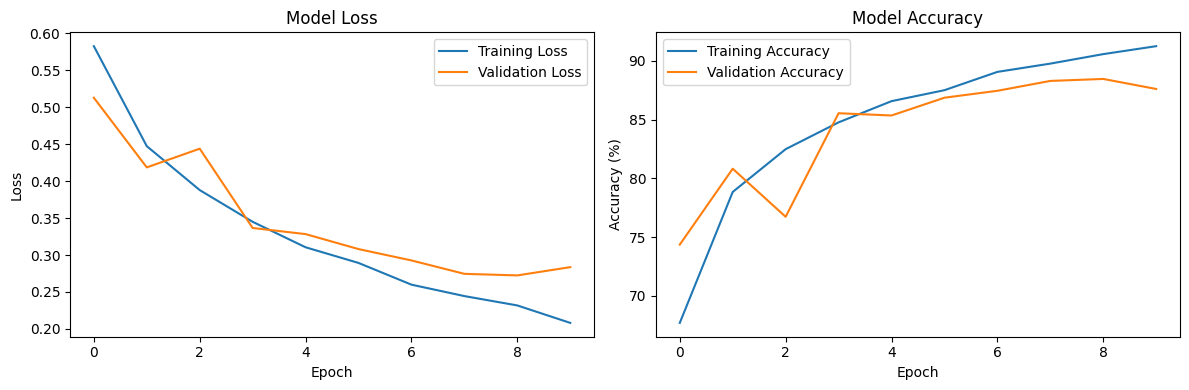

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Final evaluation
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data).squeeze()
        predicted = (output > 0.5).float()
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

final_accuracy = 100 * test_correct / test_total
print(f'\nFinal Test Accuracy: {final_accuracy:.2f}%')


Final Test Accuracy: 87.60%


# Week 5

Sentiment Analysis Using Transfer Learning with BERT

In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

In [ ]:
# Set constants
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
class IMDBDatasetBERT(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize and prepare input
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LENGTH,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor([label])
        }

In [ ]:
class BERTSentimentClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(BERTSentimentClassifier, self).__init__()

        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

        # Classification layers
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 256)  # 768 is BERT's hidden size
        self.linear2 = nn.Linear(256, 1)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # Use the [CLS] token representation

        # Classification head
        x = self.dropout(pooled_output)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return torch.sigmoid(x)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Calculate training metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100 * train_correct / train_total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate validation metrics
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        # Print epoch statistics
        print(f'\nEpoch: {epoch + 1}')
        print(f'Training Loss: {epoch_train_loss:.4f}, '
              f'Training Accuracy: {epoch_train_acc:.2f}%')
        print(f'Validation Loss: {epoch_val_loss:.4f}, '
              f'Validation Accuracy: {epoch_val_acc:.2f}%')
        print('--------------------')

    return train_losses, train_accs, val_losses, val_accs

In [ ]:
# Load and preprocess data
print("Loading IMDB dataset...")
(x_train, y_train), (x_test, y_test) = imdb.load_data()

Loading IMDB dataset...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Convert indices back to words
word_index = imdb.get_word_index()
index_word = {v: k for k, v in word_index.items()}
x_train_texts = [' '.join([index_word.get(i - 3, '') for i in text]) for text in x_train]
x_test_texts = [' '.join([index_word.get(i - 3, '') for i in text]) for text in x_test]

# Initialize tokenizer and create datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = IMDBDatasetBERT(x_train_texts, y_train, tokenizer)
test_dataset = IMDBDatasetBERT(x_test_texts, y_test, tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Initialize model, loss function, and optimizer
model = BERTSentimentClassifier().to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)  # Lower learning rate for BERT

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [9]:
# Train the model
train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, test_loader, criterion, optimizer, EPOCHS, DEVICE
)

Epoch 1/5:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch: 1
Training Loss: 0.6774, Training Accuracy: 57.94%
Validation Loss: 0.6557, Validation Accuracy: 62.48%
--------------------


Epoch 2/5:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch: 2
Training Loss: 0.6448, Training Accuracy: 64.85%
Validation Loss: 0.6189, Validation Accuracy: 70.02%
--------------------


Epoch 3/5:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch: 3
Training Loss: 0.6208, Training Accuracy: 67.23%
Validation Loss: 0.5928, Validation Accuracy: 71.73%
--------------------


Epoch 4/5:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch: 4
Training Loss: 0.6034, Training Accuracy: 68.14%
Validation Loss: 0.5729, Validation Accuracy: 73.06%
--------------------


Epoch 5/5:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch: 5
Training Loss: 0.5979, Training Accuracy: 68.46%
Validation Loss: 0.5625, Validation Accuracy: 73.15%
--------------------


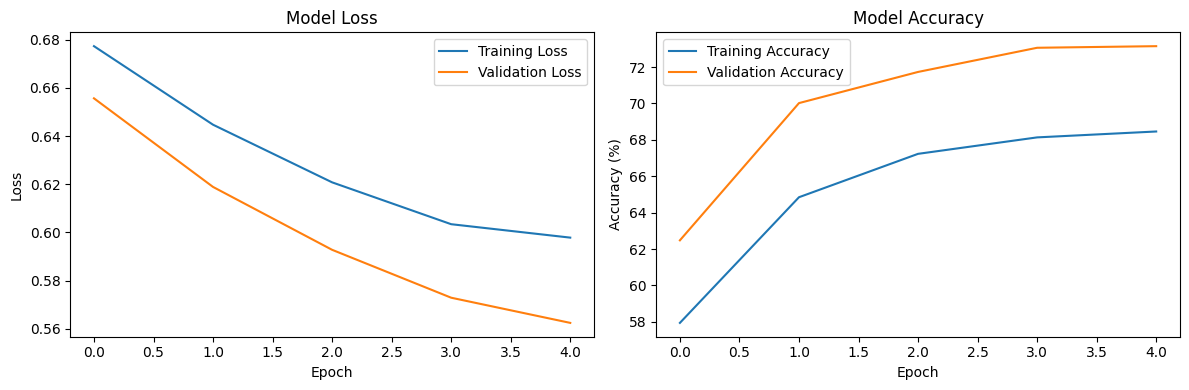

In [10]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Final evaluation
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids, attention_mask)
        predicted = (outputs > 0.5).float()
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

final_accuracy = 100 * test_correct / test_total
print(f'\nFinal Test Accuracy: {final_accuracy:.2f}%')


Final Test Accuracy: 73.15%
